In [2]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import pickle

# Load Stored Live Edges

In [8]:
live_edges_20k_point001_point3 = pickle.load(open("live_edges_20k_point001_point3", "rb"))
live_edges_20k_point001_point5 = pickle.load(open("live_edges_20k_point001_point5", "rb"))
live_edges_20k_point005_point3 = pickle.load(open("live_edges_20k_point005_point3", "rb"))
live_edges_20k_point005_point5 = pickle.load(open("live_edges_20k_point005_point5", "rb"))


# CELF

In [4]:
"""Hàm celf_outbreakP_live_edges được sử dụng để thực hiện thuật toán CELF để tối ưu
 hóa xác suất phát hiện đợt bùng phát (outbreak detection probability) dựa trên live-edge đã được xác định trước đó.

Các tham số đầu vào của hàm:

    p_initial_infect: Xác suất nhiễm bệnh ban đầu.
    p_infect: Xác suất lây nhiễm giữa các cặp node kề nhau trong mạng.
    lists_infected_nodes: Danh sách các node bị nhiễm bệnh trong từng lần mô phỏng.
    num_detectors: Số lượng detectors cần tìm.
    seed: Giá trị seed cho việc tạo số ngẫu nhiên.
    n: Số lượng node trong mạng.
    debug: Chế độ debug để in ra thông tin chi tiết trong quá trình thực hiện.
Hàm trả về hai danh sách final_outbreakP và final_runtimes,
lần lượt là danh sách các giá trị outbreak detection probability và thời gian chạy tương ứng với việc tìm các detectors."""


def celf_outbreakP_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    
    print('Running CELF to optimize detection probability w/ live edges')
    results = open("CELF_outbreak_detection_probability_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    
    final_outbreakP = []
    final_runtimes = []
    
    marginals = np.zeros(n)
    start_time = time.time()
    
    # select the first node by exhuastively computing all marginal benefits
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [1 if potential_detector in cur_infected_ids else 0 for cur_infected_ids in lists_infected_nodes]
        marginals[potential_detector - 1] = sum(runs) / float(runs_per_marginal_node)
        if debug:
            print("Straight up gain for node " + str(potential_detector) + " is: " + str(marginals[potential_detector - 1]))
    
    sorted_marginals_indices = np.argsort(marginals) # ascending order, sorted by which nodes have the best metric
    best_marginal_node = sorted_marginals_indices[-1] + 1 
    rewards_so_far = np.max(marginals) # used to track current best reward
    marginals[best_marginal_node - 1] = -99 # since we already selected it
    final_outbreakP.append(rewards_so_far)
    
    selected_detectors = [best_marginal_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    runtime = (time.time() - start_time)/60 
    print("Runtime (minutes) = " + str( runtime ))
    final_runtimes.append(runtime)
    
    results.write(str(best_marginal_node) + '\t' + str(rewards_so_far) + '\t' + str(rewards_so_far) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector")
        
        # need to re-evaluate the top node once, at least
        sorted_marginals_indices = np.argsort(marginals)
        old_top_node = sorted_marginals_indices[-1] + 1 # the top node from the previous iteration
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[old_top_node - 1] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        sorted_marginals_indices = np.argsort(marginals) # sort now that we have re-evaluted for top node
        new_top_node = sorted_marginals_indices[-1] + 1
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = sorted_marginals_indices[-1] + 1 # the top node from the previous iteration
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
            marginals[old_top_node - 1] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far

            sorted_marginals_indices = np.argsort(marginals) # sort now that we have re-evaluted for top node
            new_top_node = sorted_marginals_indices[-1] + 1
        
        
        
        best_node = new_top_node
        
        print("After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + marginals[best_node - 1] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginals[best_node - 1]) + '\t' + str(runtime) + '\n')
        final_outbreakP.append(rewards_so_far)
        final_runtimes.append(runtime)
        
        marginals[best_node - 1] = -99
        print("Outbreak detection probability so far: " + str(rewards_so_far))
        print("Runtime (minutes) so far = " + str( runtime ))
        
                 
    results.close()
    
    return final_outbreakP, final_runtimes

# Pure Social Score

In [5]:
def run_social_score(p_initial_infect, p_infect, lists_infected_nodes, num_detectors):

    final_outbreakP = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_nodes)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        outbreakP = sum( [bool(set(selected_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] ) / float(runs_per_marginal_node) # check if any detectors are in the list of infected nodes
        marginal = outbreakP - rewards_so_far
        rewards_so_far = outbreakP
        final_outbreakP.append(rewards_so_far)
        print("After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector]))
        print("Outbreak detection probability so far: " + str(rewards_so_far))
        print("Marginal gain = " + str(marginal))
        runtime = (time.time() - start_time) / 60
        print("Runtime (minutes) = " + str(runtime))
        final_runtimes.append(runtime)
    
    return final_outbreakP, final_runtimes



# CELF w/ Social Score Speed-ups

In [13]:
def speedup_outbreakP_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    final_outbreakP = []
    final_runtimes = []
    
    print('Running CELF w/ social score speed ups to optimize detection probability w/ live edges')
    results = open("CELF_outbreakP_live_edge_speedup.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )    
    
    
 
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    marginals = {} # dictionary of marginals
    start_time = time.time()
    
    # selecting the first detector
    for potential_detector in social_score_nodes[:look_ahead]: 
        runs = [1 if potential_detector in cur_infected_ids else 0 for cur_infected_ids in lists_infected_nodes]
        marginals[potential_detector] = sum(runs) / float(runs_per_marginal_node)
        if debug:
            print("Straight up gain for node " + str(potential_detector) + " is: " + str(marginals[potential_detector]))
    
    best_marginal_node = max( marginals.items(), key=operator.itemgetter(1) )[0] # grab best node
    rewards_so_far = marginals[best_marginal_node]
    final_outbreakP.append(rewards_so_far)
    del marginals[best_marginal_node]
    
    selected_detectors = [best_marginal_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    runtime = (time.time() - start_time)/60
    final_runtimes.append(runtime)
    print("Runtime (minutes) = " + str( runtime ))
    
    results.write(str(best_marginal_node) + '\t' + str(rewards_so_far) + '\t' + str(rewards_so_far) + '\n' )
    
    
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector")
        
        # add one new detector from social score
        new_detectors = list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector) # since we want to start from the look-ahead mark
        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[additional_detector] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        # grab the old top node and re-evaluate it
        old_top_node = max( marginals.items(), key=operator.itemgetter(1) )[0]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)
        runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
        marginals[old_top_node] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far
        
        # find the new top node
        new_top_node = max( marginals.items(), key=operator.itemgetter(1) )[0]
        
        
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node b/c the originally old top node fell out of the rankings
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [bool(set(new_detectors) & set(infected_ids)) for infected_ids in lists_infected_nodes] # check if any detectors are in the list of infected nodes
            marginals[old_top_node] = sum(runs) / float(runs_per_marginal_node) - rewards_so_far

            new_top_node = max( marginals.items(), key=operator.itemgetter(1) )[0]
        
        
        
        best_node = new_top_node
        
        print("After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + marginals[best_node] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginals[best_node]) + '\t' + str(runtime) + '\n')
        del marginals[best_node]
        print("Outbreak detection probability so far: " + str(rewards_so_far))
        
        print("Runtime (minutes) so far = " + str( runtime ))
        
        final_outbreakP.append(rewards_so_far)
        final_runtimes.append(runtime)
        
        
            
    results.close()
    
    return final_outbreakP, final_runtimes

# Comparisons - Outbreak P

p_infect = 0.3, p_initial_infect = 0.001

In [9]:
celf_outbreakP_point001_point3, celf_runtimes_point001_point3 = celf_outbreakP_live_edges(0.001, 0.3, live_edges_20k_point001_point3, 50 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 2.1245344201723735
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.4574
Runtime (minutes) so far = 5.332256631056468
After doing CELF, we have found the 3th detector w/ best marginal gain = 1952
Outbreak detection probability so far: 0.4648
Runtime (minutes) so far = 5.409517975648244
After doing CELF, we have found the 4th detector w/ best marginal gain = 547
Outbreak detection probability so far: 0.4715
Runtime (minutes) so far = 5.419448328018189
After doing CELF, we have found the 5th detector w/ best marginal gain = 1701
Outbreak detection probability so far: 0.47785
Runtime (minutes) so far = 5.429986508687337
After doing CELF, we have found the 6th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.48275
Runtime (minutes) so far = 5.470449344317118
After doing CELF, w

After doing CELF, we have found the 50th detector w/ best marginal gain = 449
Outbreak detection probability so far: 0.5417
Runtime (minutes) so far = 8.393689155578613


In [10]:
social_outbreakP_point001_point3, social_runtimes_point001_point3 = run_social_score(0.001, 0.3, live_edges_20k_point001_point3, 50 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.4206
Marginal gain = 0.4206
Runtime (minutes) = 0.0029664874076843263
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.4257
Marginal gain = 0.005100000000000049
Runtime (minutes) = 0.005590951442718506
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.441
Marginal gain = 0.01529999999999998
Runtime (minutes) = 0.009057875474294026
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.441
Marginal gain = 0.0
Runtime (minutes) = 0.011870817343393961
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.441
Marginal gain = 0.0
Runtime (minutes) = 0.015490206082661946
After doing Social Score, we have found the 6th detector = 585
Outbreak detection probability so far: 0.441
Margi

After doing Social Score, we have found the 47th detector = 993
Outbreak detection probability so far: 0.45615
Marginal gain = 0.0005499999999999949
Runtime (minutes) = 0.1774025837580363
After doing Social Score, we have found the 48th detector = 713
Outbreak detection probability so far: 0.45635
Marginal gain = 0.00019999999999997797
Runtime (minutes) = 0.18219085534413657
After doing Social Score, we have found the 49th detector = 702
Outbreak detection probability so far: 0.45635
Marginal gain = 0.0
Runtime (minutes) = 0.18692386150360107
After doing Social Score, we have found the 50th detector = 350
Outbreak detection probability so far: 0.45635
Marginal gain = 0.0
Runtime (minutes) = 0.19056280453999838


In [14]:
speedup_outbreakP_point003_point3, speedup_runtimes_point001_point3 = speedup_outbreakP_live_edges(0.001, 0.3, live_edges_20k_point001_point3, 50, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.01648772954940796
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.4466
Runtime (minutes) so far = 0.14220449527104695
After doing speed up, we have found the 3th detector w/ best marginal gain = 278
Outbreak detection probability so far: 0.44885
Runtime (minutes) so far = 0.1484136700630188
After doing speed up, we have found the 4th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.4501
Runtime (minutes) so far = 0.15521934032440185
After doing speed up, we have found the 5th detector w/ best marginal gain = 1287
Outbreak detection probability so far: 0.45115
Runtime (minutes) so far = 0.16116493542989094
After doing speed up, we have found the 6th detector w/ best marginal gain = 984
Outbreak detection probability so far: 0.4522
Runtime (m

After doing speed up, we have found the 48th detector w/ best marginal gain = 1894
Outbreak detection probability so far: 0.47615
Runtime (minutes) so far = 0.560836152235667
After doing speed up, we have found the 49th detector w/ best marginal gain = 675
Outbreak detection probability so far: 0.47655
Runtime (minutes) so far = 0.5693692843119303
After doing speed up, we have found the 50th detector w/ best marginal gain = 1522
Outbreak detection probability so far: 0.47655
Runtime (minutes) so far = 0.5774326165517171


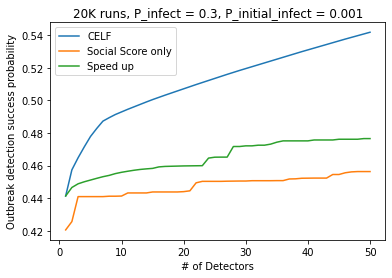

In [15]:
plt.plot(range(1, 51), celf_outbreakP_point001_point3, label="CELF")
plt.plot(range(1, 51), social_outbreakP_point001_point3, label="Social Score only")
plt.plot(range(1, 51), speedup_outbreakP_point003_point3, label="Speed up")
plt.title("20K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

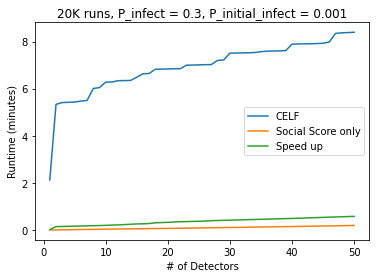

In [16]:
plt.plot(range(1,51), celf_runtimes_point001_point3, label="CELF")
plt.plot(range(1,51), social_runtimes_point001_point3, label="Social Score only")
plt.plot(range(1,51), speedup_runtimes_point001_point3 , label="Speed up")
plt.title("20K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.001, p_infect = 0.5

In [17]:

celf_outbreakP_point001_point5, celf_runtimes_point001_point5 = celf_outbreakP_live_edges(0.001, 0.5, live_edges_20k_point001_point5, 50 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 3.073346443970998
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.56505
Runtime (minutes) so far = 7.524117553234101
After doing CELF, we have found the 3th detector w/ best marginal gain = 1701
Outbreak detection probability so far: 0.5741
Runtime (minutes) so far = 7.65539391040802
After doing CELF, we have found the 4th detector w/ best marginal gain = 1952
Outbreak detection probability so far: 0.5819
Runtime (minutes) so far = 7.765666723251343
After doing CELF, we have found the 5th detector w/ best marginal gain = 547
Outbreak detection probability so far: 0.58905
Runtime (minutes) so far = 7.78594391743342
After doing CELF, we have found the 6th detector w/ best marginal gain = 1377
Outbreak detection probability so far: 0.59555
Runtime (minutes) so far = 7.8240304589271545
After doing CELF, we

After doing CELF, we have found the 50th detector w/ best marginal gain = 1700
Outbreak detection probability so far: 0.64965
Runtime (minutes) so far = 11.780535026391346


In [18]:
social_outbreakP_point001_point5, social_runtimes_point001_point5 = run_social_score(0.001, 0.5, live_edges_20k_point001_point5, 50 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.5361
Marginal gain = 0.5361
Runtime (minutes) = 0.0051087141036987305
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.5388
Marginal gain = 0.0026999999999999247
Runtime (minutes) = 0.009611395994822185
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.54425
Marginal gain = 0.005450000000000066
Runtime (minutes) = 0.013642470041910807
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.54425
Marginal gain = 0.0
Runtime (minutes) = 0.018293134371439614
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.54425
Marginal gain = 0.0
Runtime (minutes) = 0.02296132246653239
After doing Social Score, we have found the 6th detector = 585
Outbreak detection probability so far: 0.54

After doing Social Score, we have found the 48th detector = 713
Outbreak detection probability so far: 0.5563
Marginal gain = 0.0
Runtime (minutes) = 0.2602244098981222
After doing Social Score, we have found the 49th detector = 702
Outbreak detection probability so far: 0.5563
Marginal gain = 0.0
Runtime (minutes) = 0.2671327273050944
After doing Social Score, we have found the 50th detector = 350
Outbreak detection probability so far: 0.5563
Marginal gain = 0.0
Runtime (minutes) = 0.27516265710194904


In [19]:
speedup_outbreakP_point001_point5, speedup_runtimes_point001_point5 = speedup_outbreakP_live_edges(0.001, 0.5, live_edges_20k_point001_point5, 50, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.022500109672546387
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.54795
Runtime (minutes) so far = 0.20274487336476643
After doing speed up, we have found the 3th detector w/ best marginal gain = 278
Outbreak detection probability so far: 0.5503
Runtime (minutes) so far = 0.21024682521820068
After doing speed up, we have found the 4th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.55145
Runtime (minutes) so far = 0.21915513277053833
After doing speed up, we have found the 5th detector w/ best marginal gain = 1287
Outbreak detection probability so far: 0.55255
Runtime (minutes) so far = 0.22716296513875325
After doing speed up, we have found the 6th detector w/ best marginal gain = 993
Outbreak detection probability so far: 0.5533
Runtime

After doing speed up, we have found the 48th detector w/ best marginal gain = 737
Outbreak detection probability so far: 0.5765
Runtime (minutes) so far = 0.7026775598526
After doing speed up, we have found the 49th detector w/ best marginal gain = 675
Outbreak detection probability so far: 0.57655
Runtime (minutes) so far = 0.7125531355539958
After doing speed up, we have found the 50th detector w/ best marginal gain = 1586
Outbreak detection probability so far: 0.57655
Runtime (minutes) so far = 0.7221182783444723


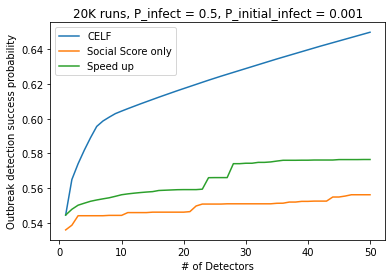

In [20]:
plt.plot(range(1, 51), celf_outbreakP_point001_point5, label="CELF")
plt.plot(range(1, 51), social_outbreakP_point001_point5, label="Social Score only")
plt.plot(range(1, 51), speedup_outbreakP_point001_point5, label="Speed up")
plt.title("20K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

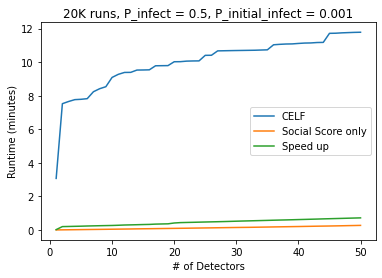

In [21]:
plt.plot(range(1,51), celf_runtimes_point001_point5, label="CELF")
plt.plot(range(1,51), social_runtimes_point001_point5, label="Social Score only")
plt.plot(range(1,51), speedup_runtimes_point001_point5, label="Speed up")
plt.title("20K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.3, runtime comparisons being done here

In [22]:
celf_outbreakP_point005_point3, celf_runtimes_point005_point3 = celf_outbreakP_live_edges(0.005, 0.3, live_edges_20k_point005_point3[:1000], 50 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[56]
Runtime (minutes) = 0.26696913242340087
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.966
Runtime (minutes) so far = 0.7372254610061646
After doing CELF, we have found the 3th detector w/ best marginal gain = 1701
Outbreak detection probability so far: 0.969
Runtime (minutes) so far = 0.9378271619478862
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Outbreak detection probability so far: 0.972
Runtime (minutes) so far = 0.9397215326627095
After doing CELF, we have found the 5th detector w/ best marginal gain = 1326
Outbreak detection probability so far: 0.974
Runtime (minutes) so far = 0.9827962358792622
After doing CELF, we have found the 6th detector w/ best marginal gain = 402
Outbreak detection probability so far: 0.976
Runtime (minutes) so far = 0.9835619886716207
After doing CELF, we 

In [23]:
speedup_outbreakP_point005_point3, speedup_runtimes_point005_point3 = speedup_outbreakP_live_edges(0.005, 0.3, live_edges_20k_point005_point3[:10000], 50, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.024502861499786376
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.9518
Runtime (minutes) so far = 0.19793589115142823
After doing speed up, we have found the 3th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.9527
Runtime (minutes) so far = 0.2038285772005717
After doing speed up, we have found the 4th detector w/ best marginal gain = 278
Outbreak detection probability so far: 0.9534
Runtime (minutes) so far = 0.20988146861394247
After doing speed up, we have found the 5th detector w/ best marginal gain = 1287
Outbreak detection probability so far: 0.954
Runtime (minutes) so far = 0.2226692756017049
After doing speed up, we have found the 6th detector w/ best marginal gain = 1753
Outbreak detection probability so far: 0.9546
Runtime (min

After doing speed up, we have found the 48th detector w/ best marginal gain = 1963
Outbreak detection probability so far: 0.9635
Runtime (minutes) so far = 0.5430047591527303
After doing speed up, we have found the 49th detector w/ best marginal gain = 1792
Outbreak detection probability so far: 0.9635
Runtime (minutes) so far = 0.5502882719039917
After doing speed up, we have found the 50th detector w/ best marginal gain = 1768
Outbreak detection probability so far: 0.9635
Runtime (minutes) so far = 0.5573503772417704


In [24]:
social_outbreakP_point005_point3, social_runtimes_point005_point3 = run_social_score(0.005, 0.3, live_edges_20k_point005_point3[:10000], 50 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.94
Marginal gain = 0.94
Runtime (minutes) = 0.005317314465840658
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.9423
Marginal gain = 0.0023000000000000798
Runtime (minutes) = 0.012115267912546794
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.9504
Marginal gain = 0.008099999999999996
Runtime (minutes) = 0.015273865063985188
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.9504
Marginal gain = 0.0
Runtime (minutes) = 0.01833504835764567
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.9504
Marginal gain = 0.0
Runtime (minutes) = 0.02157278855641683
After doing Social Score, we have found the 6th detector = 585
Outbreak detection probability so far: 0.9504
Margin

After doing Social Score, we have found the 48th detector = 713
Outbreak detection probability so far: 0.9564
Marginal gain = 9.999999999998899e-05
Runtime (minutes) = 0.20751336415608723
After doing Social Score, we have found the 49th detector = 702
Outbreak detection probability so far: 0.9564
Marginal gain = 0.0
Runtime (minutes) = 0.21169282992680868
After doing Social Score, we have found the 50th detector = 350
Outbreak detection probability so far: 0.9564
Marginal gain = 0.0
Runtime (minutes) = 0.21540074745814006


In [25]:
speedup_outbreakP_point005_point3

[0.95,
 0.9518,
 0.9527,
 0.9534,
 0.954,
 0.9546,
 0.9551,
 0.9555,
 0.9559,
 0.9565,
 0.9569,
 0.9571,
 0.9573,
 0.9574,
 0.9575,
 0.9579,
 0.958,
 0.9581,
 0.9581,
 0.9581,
 0.9581,
 0.9581,
 0.9581,
 0.9601,
 0.9604,
 0.9604,
 0.9604,
 0.962,
 0.962,
 0.9621,
 0.9621,
 0.9624,
 0.9624,
 0.9624,
 0.9627,
 0.9629,
 0.9629,
 0.9629,
 0.963,
 0.963,
 0.9633,
 0.9633,
 0.9633,
 0.9633,
 0.9635,
 0.9635,
 0.9635,
 0.9635,
 0.9635,
 0.9635]

In [26]:
celf_1k_runtimes = celf_runtimes_point005_point3

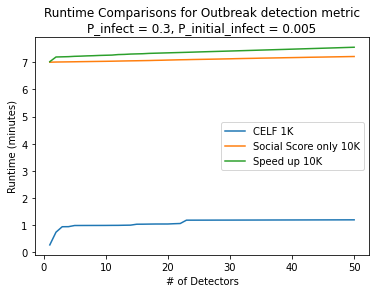

In [27]:
plt.plot(range(1,51), celf_1k_runtimes, label="CELF 1K")
plt.plot(range(1,51), [runtime + 7 for runtime in social_runtimes_point005_point3], label="Social Score only 10K")
plt.plot(range(1,51), [runtime + 7 for runtime in speedup_runtimes_point005_point3], label="Speed up 10K")
plt.title("Runtime Comparisons for Outbreak detection metric\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.5

In [28]:
celf_outbreakP_point005_point5, celf_runtimes_point005_point5 = celf_outbreakP_live_edges(0.005, 0.5, live_edges_20k_point005_point5[:1000], 20 )


Running CELF to optimize detection probability w/ live edges
We have our first best node: 
[1952]
Runtime (minutes) = 0.34467948277791344
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Outbreak detection probability so far: 0.985
Runtime (minutes) so far = 0.9024172345797221
After doing CELF, we have found the 3th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.988
Runtime (minutes) so far = 1.125523606936137
After doing CELF, we have found the 4th detector w/ best marginal gain = 167
Outbreak detection probability so far: 0.99
Runtime (minutes) so far = 1.1793493707974751
After doing CELF, we have found the 5th detector w/ best marginal gain = 915
Outbreak detection probability so far: 0.992
Runtime (minutes) so far = 1.1873708605766295
After doing CELF, we have found the 6th detector w/ best marginal gain = 2029
Outbreak detection probability so far: 0.993
Runtime (minutes) so far = 1.2241222580273947
After doing CELF, we h

In [29]:
speedup_outbreakP_point005_point5, speedup_runtimes_point005_point5 = speedup_outbreakP_live_edges(0.005, 0.5, live_edges_20k_point005_point5[:1000], 20, "socialScore_modified_unpruned.txt")

Running CELF w/ social score speed ups to optimize detection probability w/ live edges
We have our first best node: 
[453]
Runtime (minutes) = 0.002320818106333415
After doing speed up, we have found the 2th detector w/ best marginal gain = 1144
Outbreak detection probability so far: 0.982
Runtime (minutes) so far = 0.02269050677617391
After doing speed up, we have found the 3th detector w/ best marginal gain = 984
Outbreak detection probability so far: 0.983
Runtime (minutes) so far = 0.02448385159174601
After doing speed up, we have found the 4th detector w/ best marginal gain = 993
Outbreak detection probability so far: 0.984
Runtime (minutes) so far = 0.025440359115600587
After doing speed up, we have found the 5th detector w/ best marginal gain = 1874
Outbreak detection probability so far: 0.984
Runtime (minutes) so far = 0.026504794756571453
After doing speed up, we have found the 6th detector w/ best marginal gain = 1258
Outbreak detection probability so far: 0.984
Runtime (minu

In [30]:
social_outbreakP_point005_point5, social_runtimes_point005_point5 = run_social_score(0.005, 0.5, live_edges_20k_point005_point5[:1000], 20 )

After doing Social Score, we have found the 1th detector = 1874
Outbreak detection probability so far: 0.977
Marginal gain = 0.977
Runtime (minutes) = 0.00043243964513142903
After doing Social Score, we have found the 2th detector = 1258
Outbreak detection probability so far: 0.978
Marginal gain = 0.0010000000000000009
Runtime (minutes) = 0.0009430686632792155
After doing Social Score, we have found the 3th detector = 1669
Outbreak detection probability so far: 0.978
Marginal gain = 0.0
Runtime (minutes) = 0.0013662377993265788
After doing Social Score, we have found the 4th detector = 999
Outbreak detection probability so far: 0.978
Marginal gain = 0.0
Runtime (minutes) = 0.0019302288691202798
After doing Social Score, we have found the 5th detector = 511
Outbreak detection probability so far: 0.978
Marginal gain = 0.0
Runtime (minutes) = 0.00237192710240682
After doing Social Score, we have found the 6th detector = 585
Outbreak detection probability so far: 0.978
Marginal gain = 0.0


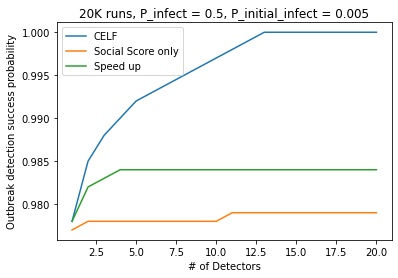

In [32]:
plt.plot(range(1, 21), celf_outbreakP_point005_point5, label="CELF")
plt.plot(range(1, 21), social_outbreakP_point005_point5, label="Social Score only")
plt.plot(range(1, 21), speedup_outbreakP_point005_point5, label="Speed up")
plt.title("20K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Outbreak detection success probability")
plt.xlabel("# of Detectors")
plt.legend()

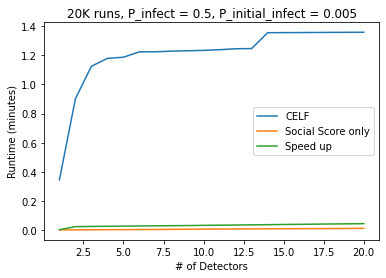

In [33]:
plt.plot(range(1,21), celf_runtimes_point005_point5, label="CELF")
plt.plot(range(1,21), social_runtimes_point005_point5, label="Social Score only")
plt.plot(range(1,21), speedup_runtimes_point005_point5, label="Speed up")
plt.title("20K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

# Save CELF Runs

In [34]:
pickle.dump(celf_outbreakP_point001_point5, open("celf_outbreakP_point001_point5", "wb"))
pickle.dump(celf_runtimes_point001_point5, open("celf_outbreakP_runtimes_point001point5", "wb"))
pickle.dump(celf_outbreakP_point005_point3, open("celf_outbreakP_point005_point3", "wb"))
pickle.dump(celf_runtimes_point005_point3, open("celf_outbreakP_runtimes_point005point3", "wb"))

In [38]:
pickle.dump(celf_outbreakP_point005_point5, open("celf_outbreakP_point005_point5", "wb"))
pickle.dump(celf_runtimes_point005_point5, open("celf_outbreakP_runtimes_point005point5","wb"))
pickle.dump(celf_outbreakP_point001_point3, open("celf_outbreakP_point001_point3", "wb"))
pickle.dump(celf_runtimes_point001_point3, open("celf_outbreakP_runtimes_point001point3", "wb"))